# Getting Started

Follow the general instructions from hw1_Q1

In [1]:
# get to the parent dir of mai_dul repo
import os

# os.chdir('../../')
os.getcwd()

'/home/ordem/PycharmProjects/MAI_DUL_WS24/homeworks/hw1'

In [2]:
# run only once at the beginning of working on hw1
# !unzip -qq homeworks/hw1/data/hw1_data.zip -d homeworks/hw1/data/

# install latest version deepul package
# !pip install -e .

In [3]:
import numpy as np
from deepul.hw1_helper import (
    # Q5
    visualize_q5_data,
    q5a_save_results,
)

# Question 5: Causal Transformer: Text

Now lets consider text! You are probably already fimilar with autoregressive transformers for text, now more commonly known as Large Language Modesl (LLMs).
We will now implement a simplified version.

We will be detailing with a [small poetry dataset](https://huggingface.co/datasets/merve/poetry). See some of the data below.

In [4]:
data = visualize_q5_data()

Sample 1
   So in Pieria, from the wedded bliss
Of Time and Memory, the Muses came
To be the means of rich oblivion,
And rest from cares.  And when the Thunderer
Took heaven, then the Titans warred on him
For pity of mankind. But the great law,
Which is the law of music, not of bread,
Set Atlas for a pillar, manacled
His brother to the rocks of the Scythia,
And under Aetna fixed the furious Typhon.
So should thought rule, not force. And Amphion,
Pursuing justice, entered Thebes and slew
His mother's spouse; but when he would make sure
And fortify the city, then he took
The lyre that Hermes gave, and played, and watched
The stones move and assemble, till a wall
Engirded Thebes and kept the citadel
Beyond the reach of arrows and of fire.
What other power but harmony can build
A city, and what gift so magical
As that by which a city lifts its walls?
So men, in years to come, shall feel the power
Of this man moving through the high-ranged thought
Which plans for beauty, builds for larger l

## Part (a) Modeling Text
Train a transformer on the poetry dataset.

Data Preprocessing:
* We will use a simple method to tokenize the data. We will convert each unique character into a token. (Current LLMs use more sophisticated tokenizers, most commonly, [byte-pair encoding](https://huggingface.co/learn/nlp-course/chapter6/5?fw=pt))
* Previously we have leveraged a **\<bos\>** as part of the model, just like iGPT. For text, we may not always sample a sequence that starts at the beginning. Instead, we will add the **\<bos\>** token to the beginning of every sequence in the dataset, and remove the **\<bos\>** token from the model.
* Another problem is that the model must know when to stop sampling. This is done by appending an **\<eos\>**, or end of sequence token at the end of every sequence in the dataset.
* We can now convert the sequence into subsequences of size context_length, for training!

We recommend the following hyperparameters:
* Sequence length: 128
* 5 epochs

**You will provide these deliverables**

1. Over the course of training, record the average negative log-likelihood (nats / dim) of the training data (per minibatch) and test data (for your entire test set). Code is provided that automatically plots the training curves. 
2. Report the final test set performance of your final model
3. Provide **5 unconditional samples** of **128 characters** showcasing the model text generation capabilities (text samples should stop after **\<eos\>**. Text after **\<eos\>** can be removed in post processing)

In [5]:

from models.GATModel import GATModel
from torch.optim import Adam
from torch.utils.data import TensorDataset, DataLoader
import math
import torch


def create_non_overlapping_windows(tokens, context_size, padding):
    tokens_tensor = torch.tensor(tokens)
    padded_length = context_size * math.ceil(len(tokens) / context_size)
    return torch.cat((tokens_tensor, torch.full((padded_length - len(tokens),), padding)), dim=0).unflatten(0, (
    context_size, padded_length // context_size))


def q5_a(train_text, test_text):
    """
    train_text: list[str] Train text sequences.
    test_text: list[str] Test text sequences.
    
    Returns
    - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
    - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
    - a list of 5 (str), 5 generated samples from the model.
    """
    batch_size = 128
    learning_rate = 0.00001
    max_epochs = 5
    context_length = 128
    vocabulary = ["<bos>", *list(set("".join(train_text + test_text))), "<eos>"]
    vocab_to_index = {value: index + 1 for index, value in enumerate(vocabulary)}

    x_train = [item for text in train_text for item in [0, *[vocab_to_index[c] for c in text], len(vocabulary) - 1]]
    x_test = [item for text in train_text for item in [0, *[vocab_to_index[c] for c in text], len(vocabulary) - 1]]
    x_train = create_non_overlapping_windows(x_train, context_length, len(vocabulary) - 1).T
    x_test = create_non_overlapping_windows(x_test, context_length, len(vocabulary) - 1).T

    train_dataset = TensorDataset(x_train)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    test_dataset = TensorDataset(x_test)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

    model = GATModel(vocab_size=len(vocabulary))
    model.to(device)

    optimizer = Adam(model.parameters(), lr=learning_rate)
    train_losses = []
    test_losses = []
    for epoch in range(max_epochs):
        batches = iter(train_loader)

        batch_train_loss = np.empty(len(batches))
        for i, [batch_x] in enumerate(batches):
            batch_x = batch_x.to(device)
            logits = model.forward(batch_x)

            loss = model.loss_function(logits, batch_x)
            batch_train_loss[i] = loss

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        train_losses.append(batch_train_loss.mean().item())

        model.eval()
        with torch.no_grad():
            batch_test_loss = np.empty(len(batches))
            for i, [test_batch_x] in enumerate(test_loader):
                test_batch_x=test_batch_x.to(device)
                test_logits = model.forward(test_batch_x)
                test_loss = model.loss_function(test_logits, test_batch_x)
                batch_test_loss[i] = test_loss.item()
            test_losses.append(batch_train_loss.mean())
        model.train()
        print(f"epoch {epoch + 1}/{max_epochs}, train loss: {train_losses[-1]}, test loss: {test_losses[-1]}")
    samples = model.generate(5, max_sequence_length=128, device=device).numpy(force=True)
    text_samples = ["".join([vocabulary[vi] for vi in sample]) for sample in samples]
    return train_losses, test_losses, text_samples

### Results

Once you've implemented `q5_a`, execute the cells below to visualize and save your results



epoch 1/5, train loss: 4.434163202558245, test loss: 4.434163202558245
epoch 2/5, train loss: 4.423790672847203, test loss: 4.423790672847203
epoch 3/5, train loss: 4.412553065163749, test loss: 4.412553065163749
epoch 4/5, train loss: 4.400065585545131, test loss: 4.400065585545131
epoch 5/5, train loss: 4.385988235473633, test loss: 4.385988235473633
Final Test Loss: 4.3860


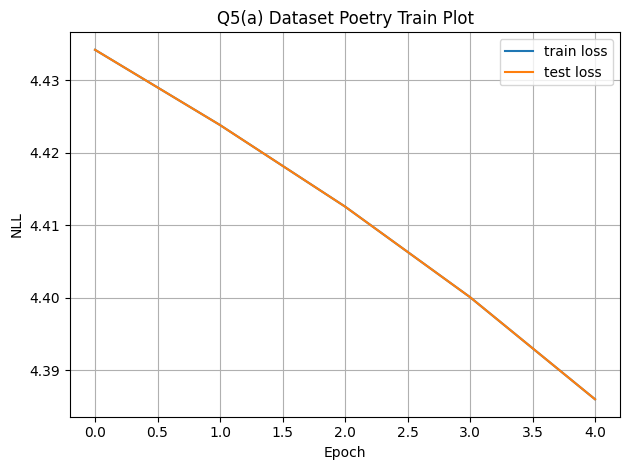

Sample 1
UMFvx]l//Z)eBb-}.Bk){V()heI-Of9!KZg7vU!
BkL}3nF5p4:gvaj4U"TKuw8RsulhF(SK5SY?T&?56
--x-bn]u(.ACI]r'tv5i

Sample 2
/WtTJc[zqBHb179l[zH:.TEx1Xm8&hPgPBTQdd82}.MD02kHvDcy4pEc8k<bos>ZoR{-[Eu03Mxo
)Pj&3n45
e:m9h?cJxEbvU0Y7EW!oc1R{tc9ihIGU2}w)yZ2zEDjaI

Sample 3
-TpZI&N<bos>Uk?YiMLK["qU"Sc8LJbn6nooMn/v1_Am3kqn

Sample 4
gh]5:!.;UCM,wRDgoXxR0pL[Jm0tl<bos>vb2BmZ4tyCD_}/,z:r

Sample 5
V'&Po
(txj9}<bos>[:I?fI'xg6hP9fG6?JFjy n}UvAvr_;3[Rg)SSWIZHj5:ez:pvmQRC(HqcL(ZY8s9xjksL-0HaANymh;B1sbP s;9"?,E,bE{TN;LL0I&E1[gmatf 



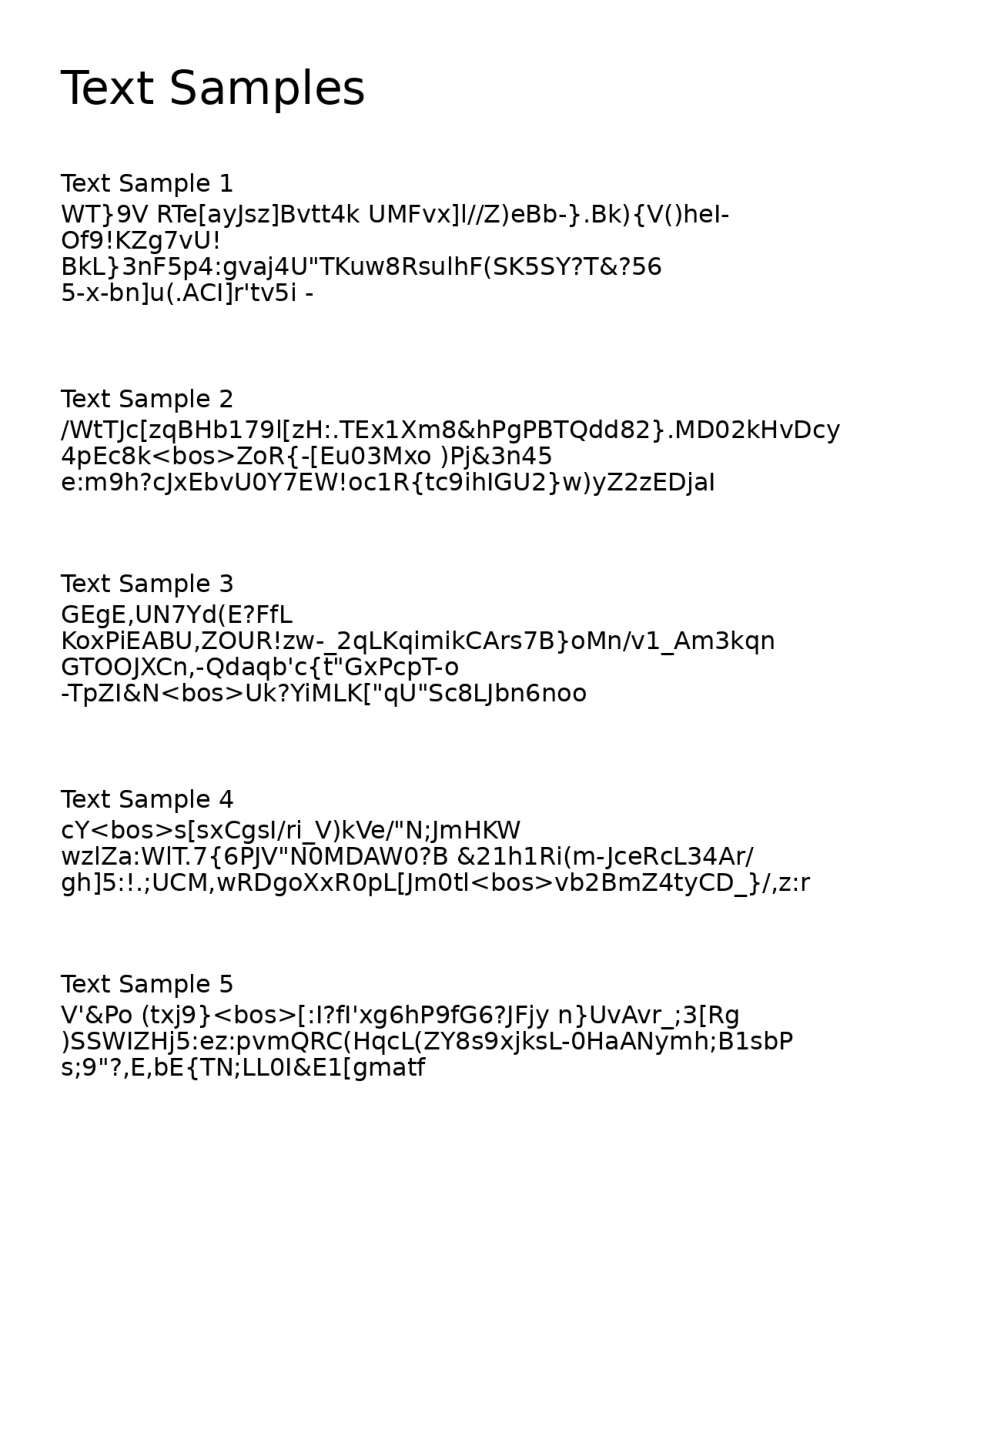

In [6]:
q5a_save_results(q5_a)